# Business Understanding
It is a matter of fact that death tolls on our roads are increased when the 
drivers are confronted with non-optimal circumstances regarding wheather and 
road conditions.
The goal of this project is to provide a guidline on how to reduce the risk 
of having a trafic accident.
In this regard, it will be attempted to predict the risk of having accident 
under given circumstances.
The calculated risk can be used as a metrics to decide whether the trip should 
be delayed or an alternative route or means of transportation should be used.


# Data Understanding
The available dataset provides a collection of all reported collisions in Seattle from 2004 to present
with many details (=features) on the occurrence. In total, 194673 rows and 38 features in the raw dataset. It could be seen that about 30% of collisions are categorie 2 (injury) and the rest categorie 1 (prop damage). No data for other categories is available.

It is the aim ofthis project to identify certain correlations 
of these features with the probability and severity of accidents.

The extensive number of features is collected, with sometimes 
very high degree of detail. E.g. the type of involved party 
as well as their direction of movement when the accident occurred, 
are separated.
Attention needs to be paid for missing information. Due to 
non-continuous (categorical) features, it would make sense 
to exclude samples (rows) with incomplete set of features.


In [ ]:
import os
from pathlib import Path
import math
import time
import re
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib
#matplotlib.use('TkAgg')       # https://stackoverflow.com/questions/27147300/matplotlib-tcl-asyncdelete-async-handler-deleted-by-the-wrong-thread
import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
raw_path = r"C:\Users\ERB1SGP\Documents\Coursera\IBM Data Science\Capstone\Data-Collisions.csv"
with open(raw_path, mode='r') as csv_file:
    # csv_reader = csv.reader(csv_file, delimiter=',')
    # csv_reader = csv.DictReader(csv_file)
    # list_of_dict = list(csv_reader)
    # lines = csv_reader.readrows()
    df = pd.read_csv(raw_path)

c:\users\erb1sgp\documents\python\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df.head(5)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Selection of most important features:

'INCDTTM': a time-dependency of probability/severity of accidents is expected

'INATTENTIONIND': the usage of cell phones and also being well rested when driving are important factors governing probability/severity of accidents

'UNDERINFL': consumption of alcohol is one of the main reasons for accidents

'WEATHER': impaired view, e.g. due to havy rain

'ROADCOND': the control over the vehicle can be lost due to bad road conditions

'LIGHTCOND': unfortunate incidence of light could impair sight as well --> probably only matters during daylight

'SPEEDING': by laws of physic, the a collision will be more severe at high velocity

In [24]:
df = df[['SEVERITYCODE', 'INCDTTM', 'INATTENTIONIND', 'UNDERINFL',
         'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING']]

In [25]:
datetimes = pd.to_datetime(df['INCDTTM'], infer_datetime_format=True)

# Extraction of day of week and hour from 'INCDTTM':
df['DAYOFWEEK'] = pd.DatetimeIndex(datetimes).dayofweek
df['HOUR'] = pd.DatetimeIndex(datetimes).hour

# 
roi = (df['HOUR'] == 0) & \
      (pd.Series(pd.DatetimeIndex(datetimes).minute) == 0) & \
      (pd.Series(pd.DatetimeIndex(datetimes).second) == 0)
df['HOUR'].loc[roi] = np.nan

# delete original feature
df.drop(['INCDTTM'], axis=1, inplace=True)

c:\users\erb1sgp\documents\python\venv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [26]:
# check for empty cells
print(df.isnull().sum())

SEVERITYCODE           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
SPEEDING          185340
DAYOFWEEK              0
HOUR               30526
dtype: int64


In [27]:
# fill empty cells
df['INATTENTIONIND'].fillna("N", inplace=True)
df['SPEEDING'].fillna("N", inplace=True)

# homogenize content of 'UNDERINFL'
df['UNDERINFL'].replace(to_replace=['Y', 'N'], value=["1", "0"], inplace=True)

In [28]:
# check for empty cells
print(df.isnull().sum())
print(df.shape)

SEVERITYCODE          0
INATTENTIONIND        0
UNDERINFL          4884
WEATHER            5081
ROADCOND           5012
LIGHTCOND          5170
SPEEDING              0
DAYOFWEEK             0
HOUR              30526
dtype: int64
(194673, 9)


In [29]:
# delete every row which does not possess a value for each feature
df = df.dropna(how='any', axis=0)

In [30]:
# check how many unique values exist for each feature
print(df.nunique())
print(df.shape)

SEVERITYCODE       2
INATTENTIONIND     2
UNDERINFL          2
WEATHER           11
ROADCOND           9
LIGHTCOND          9
SPEEDING           2
DAYOFWEEK          7
HOUR              24
dtype: int64
(163704, 9)


# Data assessment

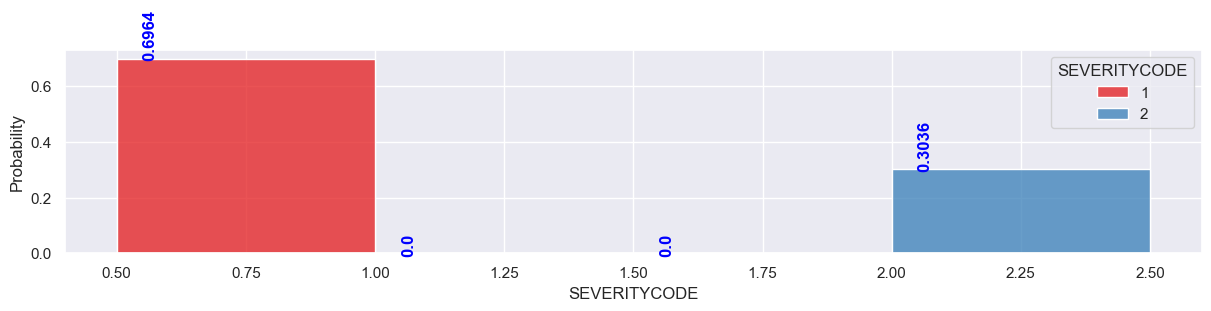

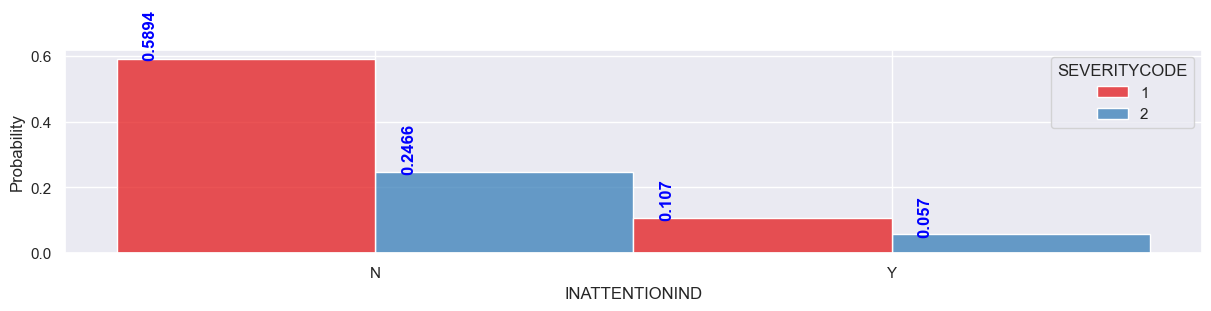

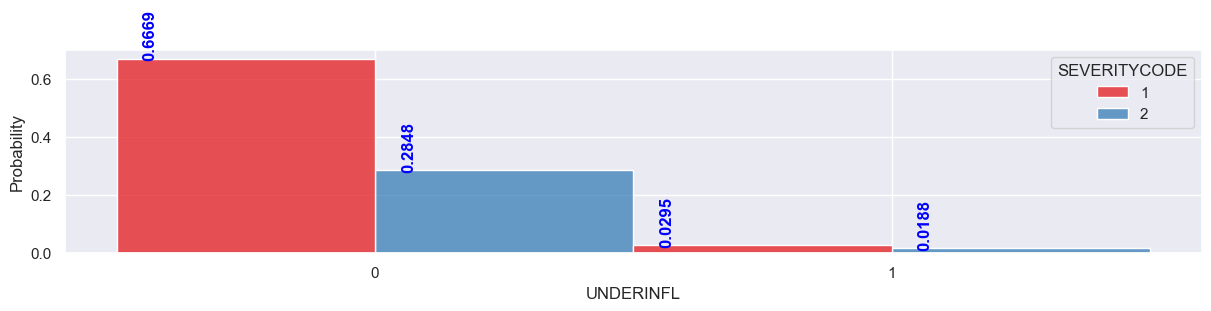

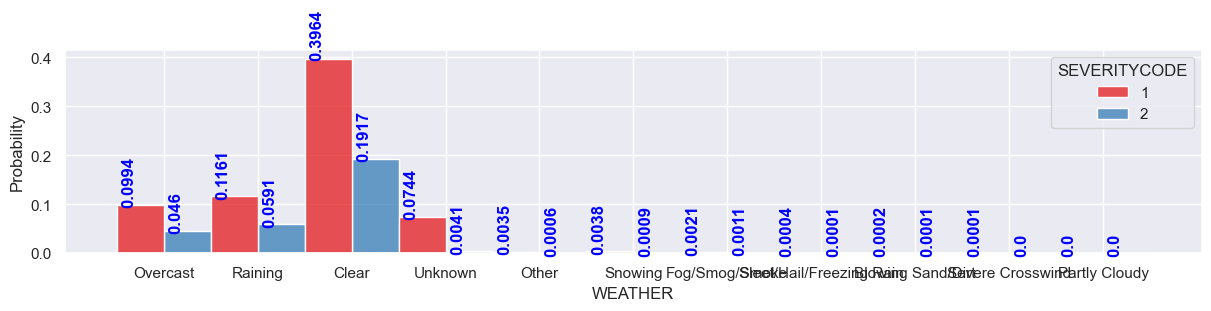

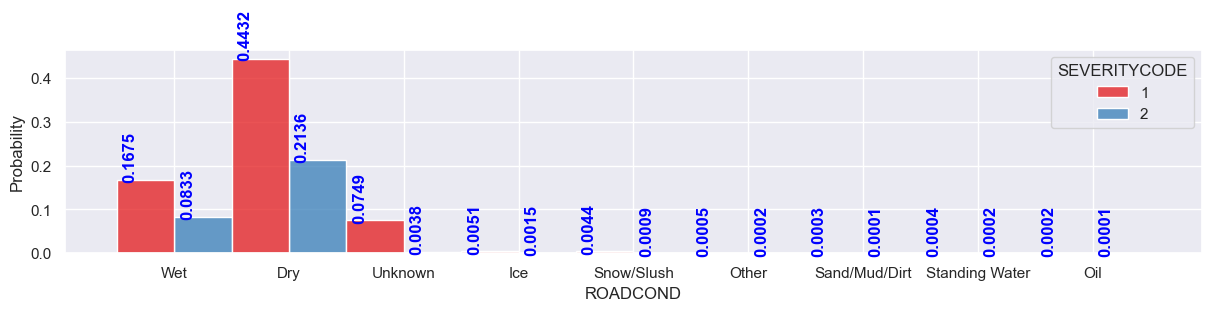

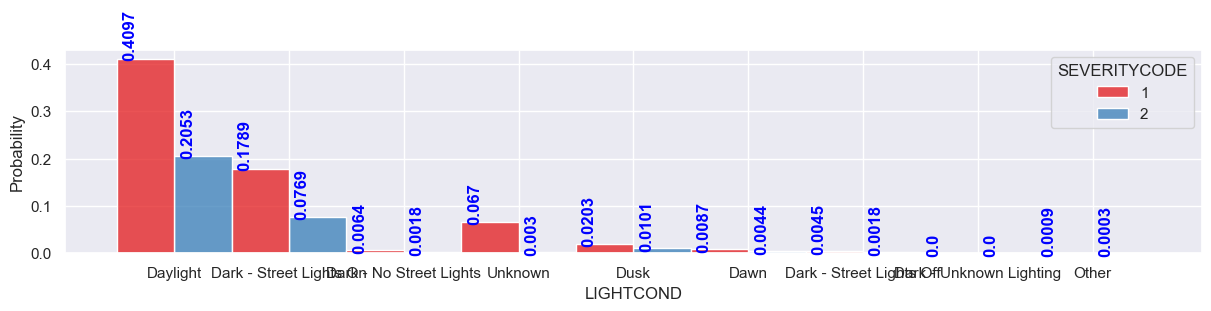

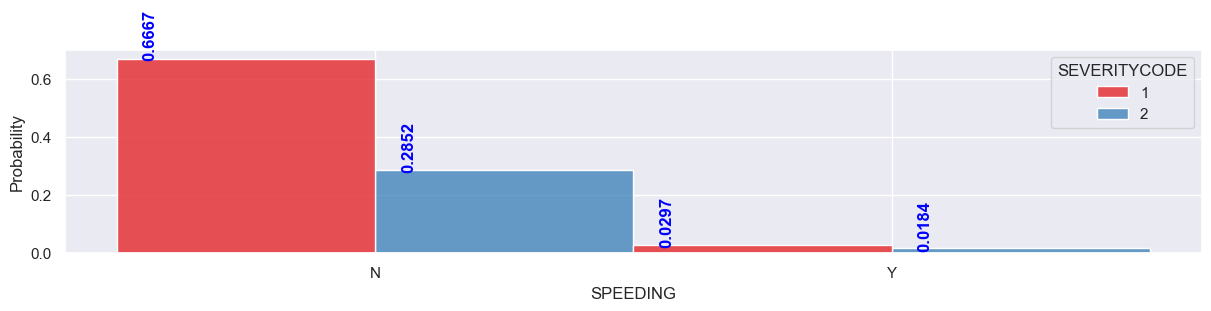

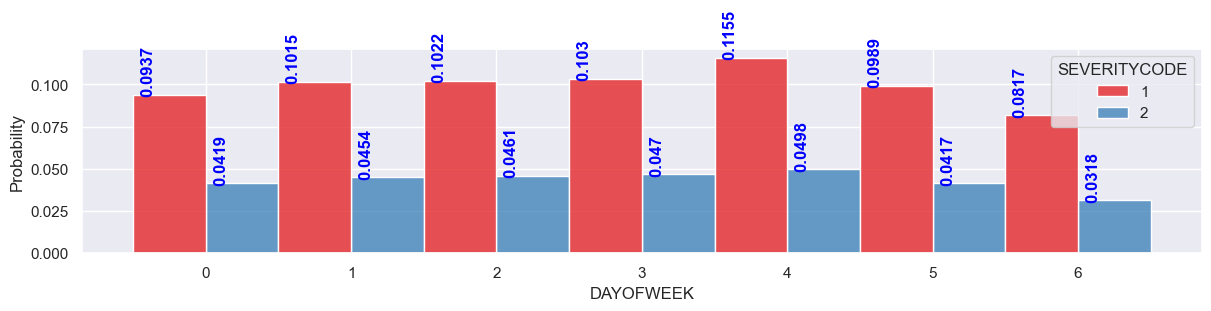

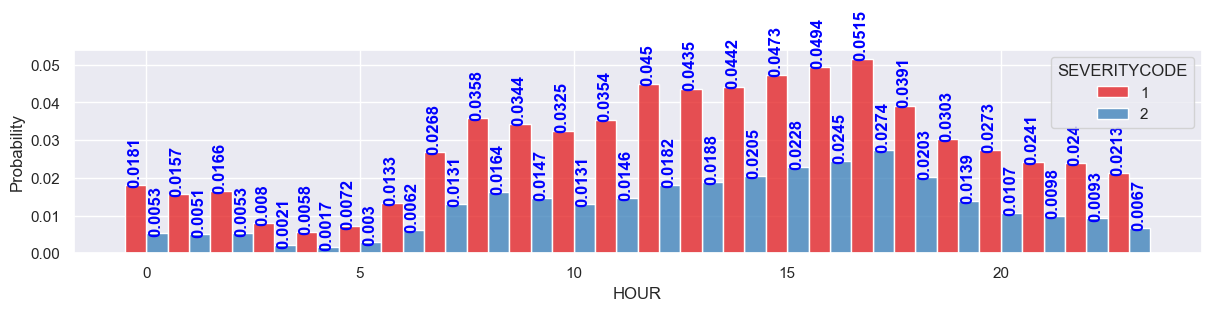

In [31]:

#Path("./Plots").mkdir(parents=True, exist_ok=True)
sns.set()
cois = df.keys()
for idx, coi in enumerate(cois):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 3], dpi=100, constrained_layout=True)
    g = sns.histplot(data=df, x=coi, y=None, stat='probability', multiple='dodge',
                     ax=ax, hue="SEVERITYCODE", palette="Set1", discrete=True
                     )
    patches_h = [h.get_height() for h in g.patches]
    patches_x = [h.get_xy()[0] for h in g.patches]
    patches_y = [h.get_xy()[1] for h in g.patches]
    for i, v in enumerate(list(zip(patches_x, patches_y, patches_h))):
        ax.text(v[0] + .05, v[2] * 1.01, str(round(v[2], 4)), color='blue', fontweight='bold',
                fontsize=12, rotation=90, rotation_mode=None)
    """strFile = f"./Plots/{coi}.png"
    if os.path.isfile(strFile):     # https://stackoverflow.com/questions/49039581/matplotlib-savefig-will-not-overwrite-old-files
       os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    plt.savefig(strFile, dpi=150)"""
    plt.show()
    plt.close()     # fig=fig

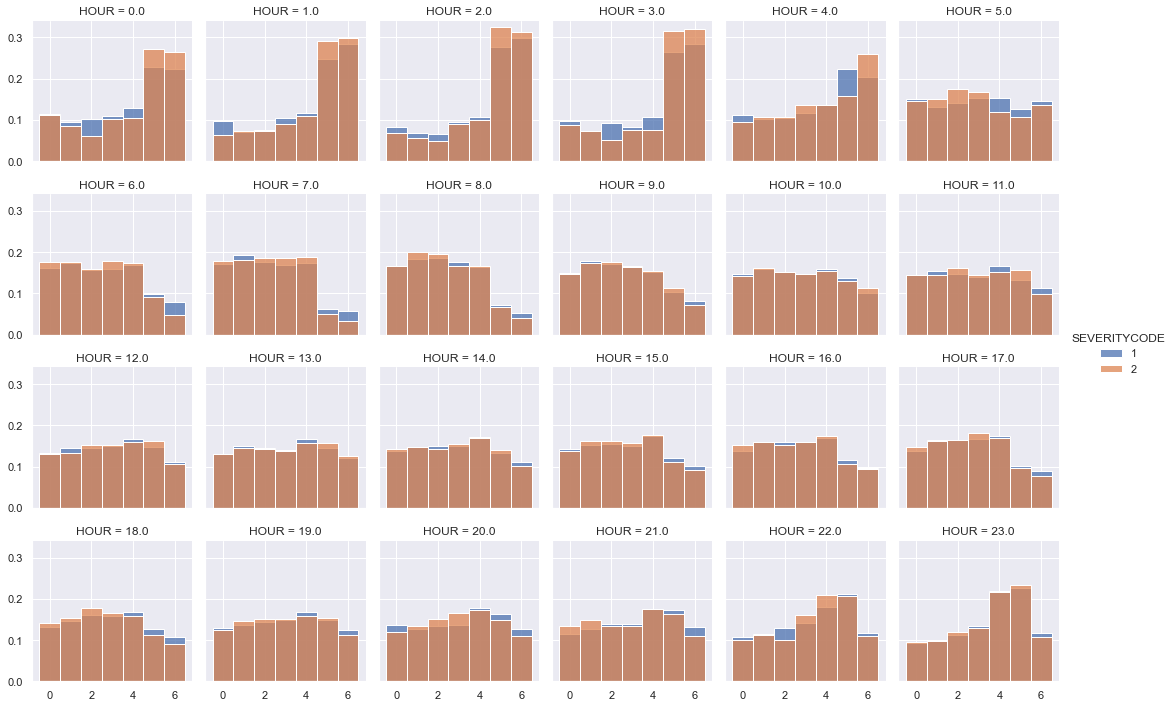

In [32]:
grid = sns.FacetGrid(data=df, col="HOUR", hue="SEVERITYCODE",
                     col_wrap=6, height=2.5)

grid.map_dataframe(sns.histplot, data=df, x="DAYOFWEEK",
                 palette="Set1", stat='probability', multiple='dodge', discrete=True)

grid.add_legend()

# Modeling

fig = plt.figure(figsize=[12.4, 6.8], dpi=100, constrained_layout=True)
corrMatrix = df.corr(method='pearson')
sns.heatmap(corrMatrix, annot=True)
plt.show(block=False)
strFile = f"./Plots/Correlation.png"
plt.savefig(strFile, dpi=150)
plt.close()     # fig=fig

In [13]:
# Pre-processing: Feature selection/extraction

y = df['SEVERITYCODE']  # target vector
del df['SEVERITYCODE']
X = df.values

cols = np.linspace(0, df.shape[1]-1, num=df.shape[1]).astype('int')
for col in cols[df.dtypes == 'object']:
    le = LabelEncoder()
    uniqueX = np.unique(X[:, col])
    le.fit(uniqueX)
    X[:, col] = le.transform(X[:, col])

print(X[0:5])


[[0 0 4 8 5 0 2 14.0]
 [0 0 6 8 2 0 2 18.0]
 [0 0 4 0 5 0 3 10.0]
 [0 0 1 0 5 0 4 9.0]
 [0 0 6 8 5 0 2 8.0]]


# one_hot_encoded
ohe = OneHotEncoder(sparse=False)
X_train_ohe = ohe.fit_transform(X)
print(X_train_ohe[0:5])
"""onehotencoder = OneHotEncoder(categorical_features=[0,1])
XX = onehotencoder.fit_transform(X).toarray()
print(X[0:5])"""

In [ ]:
# normalize
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)
X[:5]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=3)


In [16]:

from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
# print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("DecisionTrees accuracy")
print("f1 score: " + str(f1_score(y_test, yhat, average='weighted')))
print("jaccard score: " + str(jaccard_score(y_test, yhat)))

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

cm = confusion_matrix(y_test, yhat)
print(cm)
cr = classification_report(y_test, yhat)
print(cr)

DecisionTrees accuracy
f1 score: 0.5718137644087863
jaccard score: 0.6964356617085611
[[91208     0]
 [39756     0]]
              precision    recall  f1-score   support

           1       0.70      1.00      0.82     91208
           2       0.00      0.00      0.00     39756

    accuracy                           0.70    130964
   macro avg       0.35      0.50      0.41    130964
weighted avg       0.49      0.70      0.57    130964



c:\users\erb1sgp\documents\python\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
#  ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
clf = LogisticRegression(C=0.01, solver='newton-cg')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
yhat_prob = clf.predict_proba(X_test)
#from sklearn.metrics import jaccard_similarity_score
#jaccard_similarity_score(y_test, yhat)
print("LogisticRegression accuracy")
print("f1 score: " + str(f1_score(y_test, yhat, average='weighted')))
print("jaccard score: " + str(jaccard_score(y_test, yhat)))
print("Log Loss: " + str(log_loss(y_test, yhat_prob)))

#plot_confusion_matrix(clf, X_test, y_test)
cm = confusion_matrix(y_test, yhat)
print(cm)
cr = classification_report(y_test, yhat)
print(cr)

LogisticRegression accuracy
f1 score: 0.5728811935583709
jaccard score: 0.6958800696842813
Log Loss: 0.6029738428415058
[[91074   134]
 [39668    88]]
              precision    recall  f1-score   support

           1       0.70      1.00      0.82     91208
           2       0.40      0.00      0.00     39756

    accuracy                           0.70    130964
   macro avg       0.55      0.50      0.41    130964
weighted avg       0.61      0.70      0.57    130964



In [18]:

# https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
start = time.time()
#clf = svm.SVC(kernel='rbf')
# clf = OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight='auto'), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(kernel='rbf'), n_jobs=-1)
"""n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier
                          (SVC(kernel='rbf', probability=True, cache_size=2000),
                           max_samples=1.0 / n_estimators, n_estimators=n_estimators),
                          n_jobs=-1)"""
#clf = SVC(kernel='rbf')
clf = LinearSVC(random_state=0, tol=1e-05)
# clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
end = time.time()
#print("Random Forest", end - start, clf.score(X,y))
# proba = clf.predict_proba(X)
print("SVM accuracy")
print("f1 score: " + str(f1_score(y_test, yhat, average='weighted')))
print("jaccard score: " + str(jaccard_score(y_test, yhat)))

#plot_confusion_matrix(clf, X_test, y_test)
cm = confusion_matrix(y_test, yhat)
print(cm)
cr = classification_report(y_test, yhat)
print(cr)


c:\users\erb1sgp\documents\python\venv\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM accuracy
f1 score: 0.5721603164855855
jaccard score: 0.6963952955552162
[[91186    22]
 [39732    24]]
              precision    recall  f1-score   support

           1       0.70      1.00      0.82     91208
           2       0.52      0.00      0.00     39756

    accuracy                           0.70    130964
   macro avg       0.61      0.50      0.41    130964
weighted avg       0.64      0.70      0.57    130964



In [19]:
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
ConfustionMx = []
for n in range(1, Ks):
    # Train Model and Predict
    start_time = time.time()
    clf = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    # clf = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, metric='wminkowski', p=2,
    #                            metric_params={'w': np.random.random(X_train.shape[1])})
    # clf = KNeighborsClassifier(n_neighbors=n, n_jobs=-1, metric='wminkowski', p=2)
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    mean_acc[n - 1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n - 1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])
    #print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
    #print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
    print(f"KNN with k= {n} took {time.time() - start_time}")
    print(f"KNN (k= {n}) accuracy")
    print("f1 score: " + str(f1_score(y_test, yhat, average='weighted')))
    print("jaccard score: " + str(jaccard_score(y_test, yhat)))
    #plot_confusion_matrix(clf, X_test, y_test)
    cm = confusion_matrix(y_test, yhat)
    print(cm)
    cr = classification_report(y_test, yhat)
    print(cr)



KNN with k= 1 took 4.895467042922974
KNN (k= 1) accuracy
f1 score: 0.5925410822385055
jaccard score: 0.5397145888231066
[[63084 28124]
 [25676 14080]]
              precision    recall  f1-score   support

           1       0.71      0.69      0.70     91208
           2       0.33      0.35      0.34     39756

    accuracy                           0.59    130964
   macro avg       0.52      0.52      0.52    130964
weighted avg       0.60      0.59      0.59    130964

KNN with k= 2 took 5.070164918899536
KNN (k= 2) accuracy
f1 score: 0.6049625309637742
jaccard score: 0.6461204290124439
[[81207 10001]
 [34476  5280]]
              precision    recall  f1-score   support

           1       0.70      0.89      0.79     91208
           2       0.35      0.13      0.19     39756

    accuracy                           0.66    130964
   macro avg       0.52      0.51      0.49    130964
weighted avg       0.59      0.66      0.60    130964

KNN with k= 3 took 5.571870803833008
KNN (k=

The best accuracy was with 0.67380348798143 with k= 6


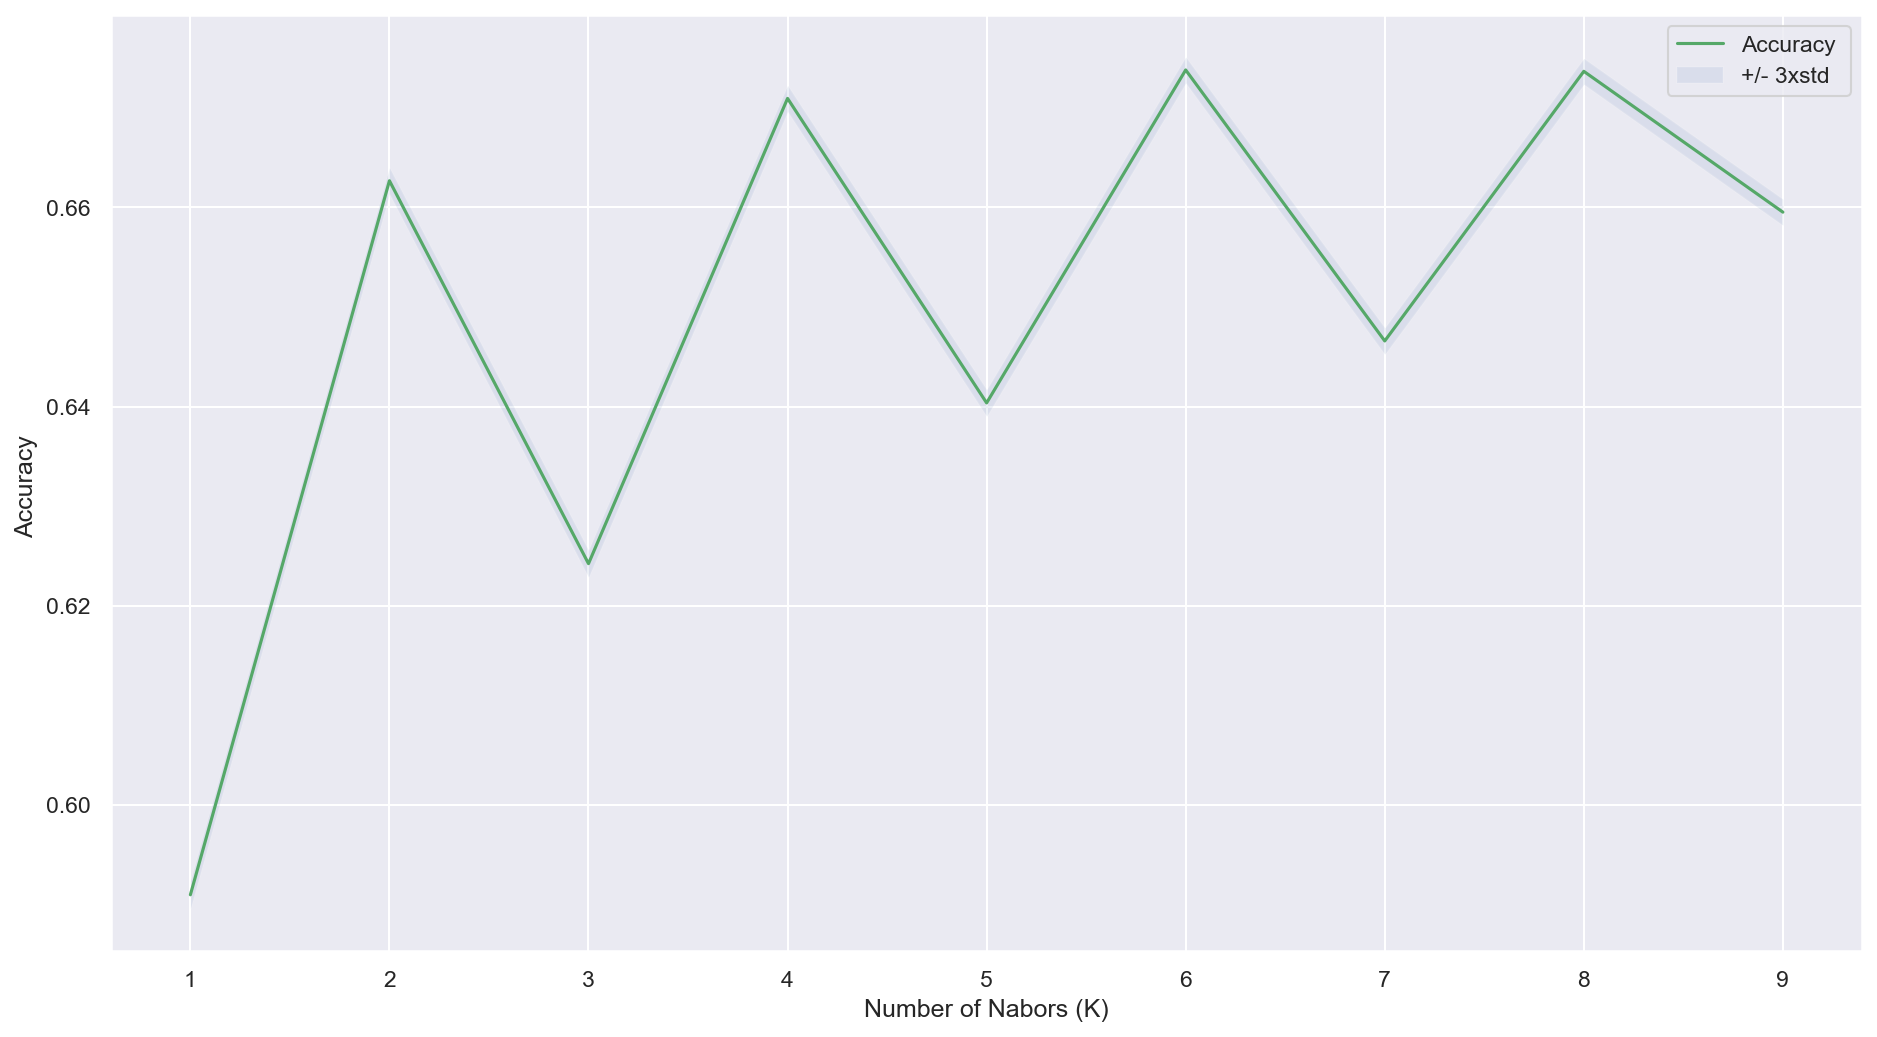

In [21]:
fig = plt.figure(figsize=[12.4, 6.8], dpi=150, constrained_layout=True)
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
# plt.tight_layout()
# plt.show()
#strFile = f"./Plots/KNN.png"
#plt.savefig(strFile, dpi=150)
#plt.close()     # fig=fig
print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

### Results

| Classifier | f1 score | jaccard score | log loss |
| --- | --- | --- | --- |
| KNN (k=8) | 0.6025756214094656 | 0.659787832536549 | N/A |
| Decision Tree | 0.5722303145913911 | 0.6967086937399208 | N/A |
| SVM | 0.5734033971092973 | 0.6965685016075598 | N/A |
| Logistic Regression | 0.6022789278407159 | 0.5742063298880061 | 0.6960382597208802 |

# Conclusion




It is very hard to use 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING' to predict occurrence since it is not known how many trips there were without any accident under the given circumstances. However, these features are still valuable to assess the severity of potential accidents.

In this regard, the features 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING' show that the ratio of level 2 collisions are significantly above 30%, which means a higher risk of more severe accident when the driver does not pay attention, is drunk or is speeding.

The most intriguing finding is that the lowest number of accidents are occurring between 6 to 9 o'clock in the morning. However, no significant impact of incident time on the severity can be observed.

In conclusion, it can be stated that non-urgent trips should be carried out considering following requirements:
- pay attention to the traffic, i.e. do no use your cell phone, etc.
- do not be under influence of alcohol, medicaments or drugs while driving
- adhere to the speed limits
- drive between  6 to 9am


The best way to predict the occurrence and severity of a collision is to use a KNN classifier with k=8. All other investigated classifiers (SVM, Decision Tree, Logistic Regression) show extremely bad recall performance for categorie 2. This means that categorie 2 was hardly ever predicted using latter three classifiers.